# Correspondence Autoencoder CNN for Acoustic Word Embeddings

Herman Kamper, Stellenbosch University, 2019.

## Preliminaries

In [770]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [771]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

import batching
import data_io
import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Data

In [792]:
# Training data

# # NumPy archive (UTD)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.utd.dd.npz")
#     )

# NumPy archive (ground truth)
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff.dd.npz")
    )

# # NumPy archive (larger ground truth)
# npz = np.load(
#     path.join("..", "features", "mfcc", "buckeye", "devpart1.samediff2.dd.npz")
#     )

# Data and labels
i_type = 0
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5109
E.g. item shape: (51, 39)


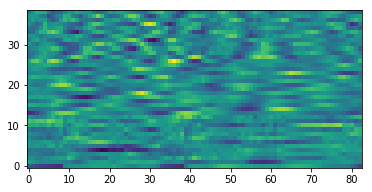

In [793]:
plt.imshow(train_x[3277].T, origin="bottom");

In [794]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart2.samediff.dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = utt_key.split("_")[0]
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2732
E.g. item shape: (61, 39)


In [795]:
# Truncate and limit dimensionality
max_length = 101
d_frame = 13
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

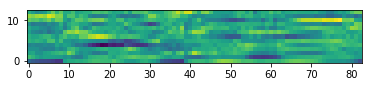

In [796]:
plt.imshow(train_x[3277].T, origin="bottom");

In [797]:
# Zero-pad and reshape
train_x, _, train_mask = data_io.pad_sequences(train_x, max_length, True, return_mask=True)
val_x, _, val_mask = data_io.pad_sequences(val_x, max_length, True, return_mask=True)
train_x = np.transpose(train_x, (0, 2, 1))
val_x = np.transpose(val_x, (0, 2, 1))

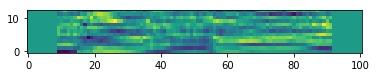

In [798]:
i_item = 3227
plt.imshow(train_x[i_item], origin="bottom");

In [799]:
print("Mask from", np.where(train_mask[i_item] == 1)[0][0], "to", np.where(train_mask[i_item] == 1)[0][-1] + 1)

Mask from 9 to 92


## AE-CNN

In [800]:
def get_conv2d_transpose_output_shape(input_shape, filter_shape, stride=1):
    """
    Calculate the output shape of a transposed convolution operation.
    
    See https://stackoverflow.com/questions/46885191.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    filter_height = filter_shape[0]
    filter_width = filter_shape[1]
    output_height = (input_height - 1)*stride + filter_height
    output_width = (input_width - 1)*stride + filter_width
    return [input_shape[0], output_height, output_width, filter_shape[2]]


def get_conv2d_transpose_filter_shape(input_shape, output_shape, stride=1):
    """
    Calculate the filter shape of a transposed convolution given a desired output shape.
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    output_shape : list
        The shape of the output to the CNN as [n_data, height, width, d_out].

    Return
    ------
    filter_shape : list
        The filter shape of as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    output_height = output_shape[1]
    output_width = output_shape[2]
    filter_height = output_height - (input_height - 1)*stride
    filter_width = output_width - (input_width - 1)*stride
    return [filter_height, filter_width, output_shape[3], input_shape[3]]


In [801]:
def build_ae_cnn(x, input_shape, filter_shapes, pool_shapes,
        build_latent_func, latent_func_kwargs, strides=None):
    """
    Build an autoencoding CNN.

    See `tflego.build_cnn` for more details on the parameters.

    Parameters
    ----------
    x : Tensor [n_data, n_input]
        Input to the CNN, which is reshaped to match `input_shape`.
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    build_latent_func : function
        The function to build the latent layer inbetween the CNN encoder and decoder.
        The function's first parameter should be the input Tensor, and it should return
        a dictionary with an element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    """
    
    # Encoder
    network_input_shape = input_shape
    print("CNN input shape: {}".format(input_shape))
    encoder, layer_shapes = tflego.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="VALID", return_shapes=True, strides=strides)
    encoder = tf.contrib.layers.flatten(encoder)
    
    # Latent layer
    latent_layer = build_latent_func(encoder, **latent_func_kwargs)
    x = latent_layer["y"]
    d_latent_layer_output = x.get_shape().as_list()[-1]
    
    # Replace None with -1 in `layer_shapes`
    for i, layer in enumerate(layer_shapes):
        layer_shapes[i] = [i if i is not None else -1 for i in layer]
    decoder_pool_shapes = pool_shapes.copy()
    
    # Decoder
    i_layer = 0
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        x = tf.reshape(x, layer_shapes.pop(-1))
        print("CNN transpose layer {} shape: {}".format(i_layer, x.get_shape().as_list()))
        decoder = tflego.build_unmaxpool2d(x, decoder_pool_shapes.pop(-1))
    while len(decoder_pool_shapes) > 0:
        i_layer += 1
        with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):

            # Transposed convolution
            input_shape = decoder.get_shape().as_list()
            output_shape = layer_shapes.pop(-1)
            if strides is not None:
                stride = strides.pop(-1)
            else:
                stride = 1
            filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape, stride)
            decoder = tflego.build_conv2d_transpose(decoder, filter_shape, stride)
            print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

            # Unpool
            decoder = tflego.build_unmaxpool2d(decoder, decoder_pool_shapes.pop(-1))

    # Last decoder linear layer
    i_layer += 1
    with tf.variable_scope("cnn_trans_layer_{}".format(i_layer)):
        input_shape = decoder.get_shape().as_list()
        output_shape = network_input_shape
        filter_shape = get_conv2d_transpose_filter_shape(input_shape, output_shape)
        decoder = tflego.build_conv2d_transpose(decoder, filter_shape, activation=tf.identity)
        print("CNN transpose layer {} shape: {}".format(i_layer, decoder.get_shape().as_list()))

    return {"latent_layer": latent_layer, "decoder_output": decoder}

In [807]:
tf.reset_default_graph()

# Data
d_in = train_x.shape[1]*train_x.shape[2]
train_x_array = train_x.reshape((-1, d_in))
val_x_array = val_x.reshape((-1, d_in))
pair_list = batching.get_pair_list(train_labels)

# Training parameters
learning_rate = 0.001
ae_n_epochs = 150
ae_n_val_interval = 25
ae_batch_size = 600

# Model parameters
input_shape = [-1, train_x.shape[1], train_x.shape[2], 1]  # [n_data, height, width, channels]
# filter_shapes = [
#     [13, 9, 1, 100],
#     [1, 8, 100, 100],
#     [1, 8, 100, 200],
#     ]
# pool_shapes = [
#     [1, 1],
#     [1, 1],
#     [1, 1],
#     ]
# strides = [
#     3,
#     3,
#     1
#     ]

filter_shapes = [
#     [39, 9, 1, 96],
    [13, 8, 1, 100],
    [1, 8, 100, 100],
    [1, 20, 100, 200],
    ]
pool_shapes = [
    [1, 2],
    [1, 2],
    [1, 1],
    ]
strides = [
    1,
    1,
    1
    ]

build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],   # tune
    "n_z": 130,
    "dec_n_hiddens": [filter_shapes[-1][-1]],  # needs to be the same as channels in last conv layer
    "activation": tf.nn.relu
    }
intermediate_model_fn = path.join(output_dir, "ae_cnn.tmp.ckpt")
model_fn = path.join(output_dir, "ae_cnn.ckpt")

# Model
a = tf.placeholder(TF_DTYPE, [None, d_in])
b = tf.placeholder(TF_DTYPE, [None, d_in])
a_mask = tf.placeholder(TF_DTYPE, [None, input_shape[2]])
b_mask = tf.placeholder(TF_DTYPE, [None, input_shape[2]])

network_dict = build_ae_cnn(
    a, input_shape, filter_shapes, pool_shapes, build_latent_func, latent_func_kwargs, strides=strides
    )
latent = network_dict["latent_layer"]
z = latent["z"]
y = network_dict["decoder_output"]


# Reshape output and target to be compatible with loss
y1 = y  # temp
y = tf.transpose(y, [0, 2, 1, 3])
# print(y.get_shape().as_list()) # temp
y = tf.squeeze(y)
y2 =y # temp
y *= tf.expand_dims(b_mask, -1)  # mask output
y3 = y # temp
y_target = tf.reshape(b, input_shape[:3])
y_target1 = y_target # temp
y_target = tf.transpose(y_target, [0, 2, 1])
y_target2 = y_target # temp

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(y_target - y), -1), -1) /
    tf.reduce_sum(b_mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

CNN input shape: [-1, 13, 101, 1]
CNN layer 0 shape: [None, 1, 31, 100]
CNN layer 1 shape: [None, 1, 8, 100]
CNN layer 2 shape: [None, 1, 1, 200]
CNN transpose layer 0 shape: [None, 1, 1, 200]
CNN transpose layer 1 shape: [None, 1, 8, 100]
CNN transpose layer 2 shape: [None, 1, 31, 100]
CNN transpose layer 3 shape: [None, 13, 101, 1]


In [808]:
class PairedMaskIterator(object):
    """Iterator over pairs of padded sequences with their masks."""
    
    def __init__(self, x_mat, mask_mat, pair_list, batch_size, shuffle_every_epoch=False):
        self.x_mat = x_mat
        self.mask_mat = mask_mat
        self.pair_list = pair_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_batches = int(np.floor(x_mat.shape[0]/batch_size))
        self.indices = np.arange(len(pair_list))
        self.shuffle()
    
    def shuffle(self):
        np.random.shuffle(self.indices)

    def __iter__(self):
        if self.shuffle_every_epoch:
            self.shuffle()
        for i_batch in range(self.n_batches):
            
            # Indices
            batch_pair_list = [
                self.pair_list[i] for i in self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size]
                ]
            batch_indices_a = [i for i, j in batch_pair_list]
            batch_indices_b = [j for i, j in batch_pair_list]

            # Batch data and mask
            batch_a = self.x_mat[batch_indices_a]
            batch_b = self.x_mat[batch_indices_b]
            batch_mask_a = self.mask_mat[batch_indices_a]
            batch_mask_b = self.mask_mat[batch_indices_b]
            
            yield (batch_a, batch_mask_a, batch_b, batch_mask_b)


In [809]:
def samediff_val(normalise=True):
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = batching.LabelledIterator(
        val_x_array, y_vec=None, batch_size=val_x.shape[0], shuffle_every_epoch=False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x in val_batch_iterator:
            np_z = session.run(
                [z], feed_dict={a: batch_x}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate(
            [val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

    # Same-different
    if normalise:
        np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
        distances = pdist(np_z_normalised, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )
    else:
        distances = pdist(np_z, metric="cosine")
        matches = samediff.generate_matches_array(labels)
        ap, prb = samediff.average_precision(
            distances[matches == True], distances[matches == False]
            )    
    return [prb, -ap]


(600, 1313) (600, 101) (600, 1313) (600, 101)
1 (600, 13, 101, 1)
2 (600, 101, 13)
5 (600, 101, 13)
max: -0.0 min: -1.2575979
3 (600, 13, 101)
4 (600, 101, 13)


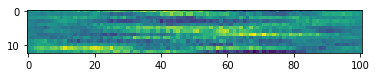

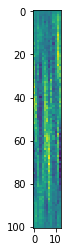

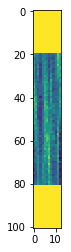

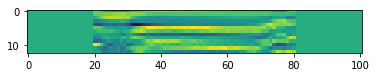

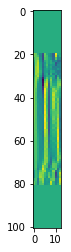

In [810]:
# Temp

train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
    )

for a_np, a_mask_np, b_np, b_mask_np in train_batch_iterator:
    print(a_np.shape, a_mask_np.shape, b_np.shape, b_mask_np.shape)

    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        
        # Output
        tf_output1 = y1.eval({a: a_np})
        tf_output2 = y2.eval({a: a_np})
        tf_output5 = y3.eval({a: a_np, b_mask: b_mask_np})
        tf_output3 = y_target1.eval({b: b_np})
        tf_output4 = y_target2.eval({b: b_np})
    break

print("1", tf_output1.shape)
plt.figure();
plt.imshow(tf_output1[0, :, :, 0]);

print("2", tf_output2.shape)
plt.figure();
plt.imshow(tf_output2[0, :, :]);

print("5", tf_output5.shape)
print("max:", np.max(tf_output5), "min:", np.min(tf_output5),)
plt.figure();
plt.imshow(tf_output5[0, :, :]);

print("3", tf_output3.shape)
plt.figure();
plt.imshow(tf_output3[0, :, :]);

print("4", tf_output4.shape)
plt.figure();
plt.imshow(tf_output4[0, :, :]);

# plt.imshow(tf_output2[])

In [811]:
# Train AE

np.random.seed(1)

train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn

record_dict = training.train_fixed_epochs_external_val(
    ae_n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_mask, b, b_mask], samediff_val,
    save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=ae_n_val_interval
    )

2019-06-07 15:38:51.863240
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae_cnn.tmp.ckpt
2.892 sec, train loss: 1.1443589, val loss: [0.09344346928239546, -0.03622092336578237] *
Epoch 1:
0.179 sec, train loss: 1.0296736
Epoch 2:
0.170 sec, train loss: 1.0203543
Epoch 3:
0.173 sec, train loss: 1.0167379
Epoch 4:
0.171 sec, train loss: 1.0126251
Epoch 5:
0.168 sec, train loss: 0.99458754
Epoch 6:
0.165 sec, train loss: 0.9663625
Epoch 7:
0.165 sec, train loss: 0.93168855
Epoch 8:
0.172 sec, train loss: 0.9106816
Epoch 9:
0.169 sec, train loss: 0.894838
Epoch 10:
0.166 sec, train loss: 0.8761876
Epoch 11:
0.165 sec, train loss: 0.8574052
Epoch 12:
0.164 sec, train loss: 0.83659637
Epoch 13:
0.166 sec, train loss: 0.8211955
Epoch 14:
0.164 sec, train loss: 0.8021958
Epoch 15:
0.164 sec, train loss: 0.7877265
Epoch 16:
0.168 sec, train loss: 0.76505345
Epoch 17:
0.165 sec, train loss: 0.74912655
Epoch 18:
0.163 sec, train loss: 0.73060477
Epoch 19:
0.173 sec, train l

KeyboardInterrupt: 

In [ ]:
# Embed validation
normalise = True
# val_batch_iterator = batching.LabelledIterator(
#     val_x_array, y_vec=None, batch_size=val_x.shape[0], shuffle_every_epoch=False
#     )
val_batch_iterator = PairedMaskIterator(
    val_x_array, val_mask,  [(i, i) for i in range(val_x.shape[0])], batch_size=val_x.shape[0], shuffle_every_epoch=False
    )
# PairedMaskIterator(
#     train_x_array, train_mask, [(i, i) for i in range(train_x.shape[0])], ae_batch_size, shuffle_every_epoch=True
#     )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, val_model_fn)
    for batch_x, batch_x_mask, _, _ in val_batch_iterator:
        np_x = np.reshape(batch_x, input_shape[:3])
        np_z = session.run(
            [z], feed_dict={a: batch_x}
            )[0]
        np_y = session.run(
            [y], feed_dict={a: batch_x, b_mask: batch_x_mask}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate(
        [val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

# Same-different
if normalise:
    np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
    distances = pdist(np_z_normalised, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )
else:
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

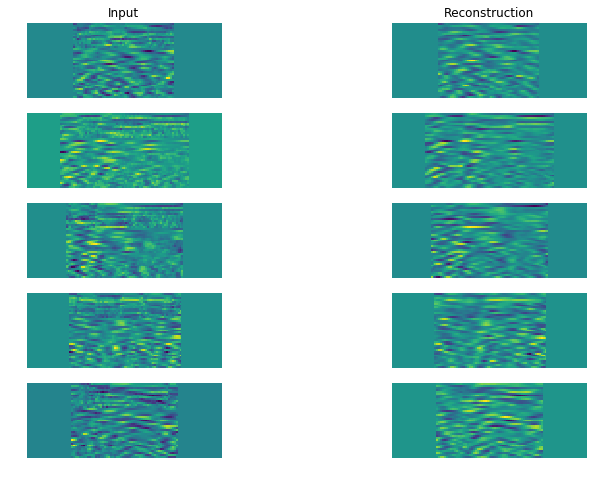

In [767]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i])
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i].T)
    plt.axis("off")

## CAE-CNN

In [686]:
cae_pretrain_model_fn = model_fn
intermediate_model_fn = path.join(output_dir, "cae_cnn.tmp.ckpt")
model_fn = path.join(output_dir, "cae_cnn.ckpt")

In [687]:
# Training parameters
learning_rate = 0.001
cae_n_epochs = 50
cae_n_val_interval = 5
cae_batch_size = 300

In [688]:
# Train CAE
train_batch_iterator = PairedMaskIterator(
    train_x_array, train_mask, pair_list, cae_batch_size, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn

cae_record_dict = training.train_fixed_epochs_external_val(
    cae_n_epochs, optimizer, loss,
    train_batch_iterator, [a, a_mask, b, b_mask],
    samediff_val, save_model_fn=intermediate_model_fn,
    save_best_val_model_fn=model_fn,
    n_val_interval=cae_n_val_interval,
    load_model_fn=cae_pretrain_model_fn
    )


2019-06-07 15:12:27.475221
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/ae_cnn.ckpt
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
3.113 sec, train loss: 0.8950218, val loss: [0.24651522973670625, -0.18401649745861617] *
Epoch 1:
0.416 sec, train loss: 0.82124245
Epoch 2:
0.433 sec, train loss: 0.8058365
Epoch 3:
0.427 sec, train loss: 0.8007889
Epoch 4:
0.428 sec, train loss: 0.7938875
Epoch 5:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
2.973 sec, train loss: 0.7923319, val loss: [0.2516778523489933, -0.1978692006497748] *
Epoch 6:
0.479 sec, train loss: 0.78480715
Epoch 7:
0.473 sec, train loss: 0.7858993
Epoch 8:
0.430 sec, train loss: 0.7813021
Epoch 9:
0.430 sec, train loss: 0.77883404
Epoch 10:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/cae_cnn.tmp.ckpt
2.983 sec, train loss: 0.7728685, val loss: [0.2558379447835074, -0.20536825869637443] *
Epoch 11:
0.424 sec, train loss: 0.7